In [1]:
#import library
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing

from sklearn.model_selection import train_test_split


Kemudian, ubah dataset menjadi dataframe dengan fungsi read_csv(). Tampilkan 5 data teratas pada dataframe menggunakan fungsi head()

In [2]:
#sumber dataset https://www.kaggle.com/robikscube/hourly-energy-consumption
#Membaca file CSV dan melihat 5 baris teratas
df = pd.read_csv('/content/sample_data/AEP_hourly.csv')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [3]:
#mengetahui jumlah baris
print(len(df['Datetime']))

121273


Kita dapat mengecek apakah ada nilai yang hilang dari dataset menggunakan fungsi isnull().

In [4]:
#mengecek apakah ada data yang kosong
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [5]:
#Melakukan Plotting(Belum Di normalisasi)
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

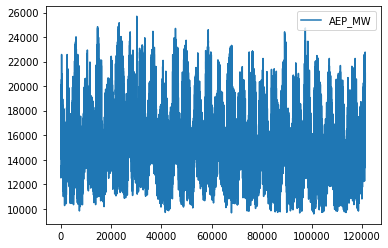

In [6]:
df.plot()
plt.show()

In [7]:
#Melakukan normalisasi dengan minmaxscaler
scaler = sklearn.preprocessing.MinMaxScaler()
df_norm = scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
df_norm.shape

(121273, 1)

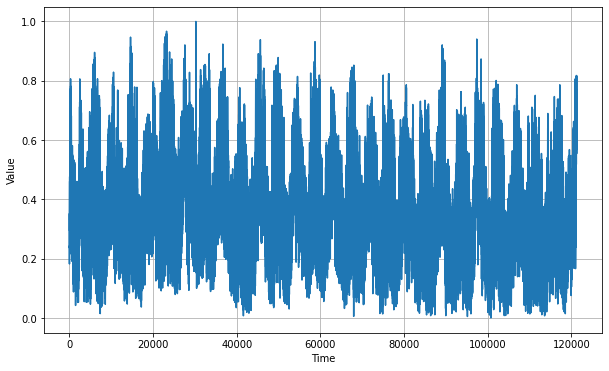

In [8]:
##Melakukan Plotting(Sesudah Di normalisasi)
power = df_norm
time = np.array(df.index)
plt.figure(figsize=(10, 6))
plot_series(time, power)

Dapat dilihat dari output cell yang kita jalankan menunjukkan bahwa data kita merupakan time series yang bersifat musiman

In [9]:

x_train, x_valid, time_train, time_valid = train_test_split(power, time, test_size = 0.2, random_state = 0 , shuffle=False)

'''
split_time = 50000
time_train = time[:split_time]
x_train = power[:split_time]
time_valid = time[split_time:]
x_valid = power[split_time:]
'''



'\nsplit_time = 50000\ntime_train = time[:split_time]\nx_train = power[:split_time]\ntime_valid = time[split_time:]\nx_valid = power[split_time:]\n'

In [10]:
print(len(x_train), len(x_valid))

97018 24255


In [11]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
#Fungsi di bawah menerima sebuah series/atribut kita yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


In [14]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

In [15]:
#Membuat model Neural Network(Coba menggunakan 1 layer LSTM)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(60,return_sequences=True),
    tf.keras.layers.Dense(10, activation ='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [16]:
#Membuat optimizer
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.05):
      print("\nMAE telah <5%!")
      self.model.stop_training = True
callbacks = myCallback()

In [18]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
#Bismillah
history = model.fit(train_set,epochs=100, callbacks=[callbacks])

Epoch 1/100
970/970 [==============================] - 31s 29ms/step - loss: 0.1032 - mae: 0.2187
Epoch 2/100
970/970 [==============================] - 27s 28ms/step - loss: 0.0074 - mae: 0.0962
Epoch 3/100
970/970 [==============================] - 28s 28ms/step - loss: 0.0064 - mae: 0.0891
Epoch 4/100
970/970 [==============================] - 27s 28ms/step - loss: 0.0057 - mae: 0.0844
Epoch 5/100
970/970 [==============================] - 28s 28ms/step - loss: 0.0053 - mae: 0.0808
Epoch 6/100
970/970 [==============================] - 27s 27ms/step - loss: 0.0049 - mae: 0.0773
Epoch 7/100
970/970 [==============================] - 27s 28ms/step - loss: 0.0045 - mae: 0.0744
Epoch 8/100
970/970 [==============================] - 27s 27ms/step - loss: 0.0042 - mae: 0.0717
Epoch 9/100
970/970 [==============================] - 27s 28ms/step - loss: 0.0040 - mae: 0.0697
Epoch 10/100
970/970 [==============================] - 27s 27ms/step - loss: 0.0038 - mae: 0.0677
Epoch 11/100
970/97

In [20]:
def plot(history, info_type='loss'):

    """
    history: the history callback from a model.fit
    info_type: what you want to show. (e.g. 'loss', 'acc', 'accuracy')
    """
    plt.plot(history.history[info_type], label=[info_type])
    try:
        plt.plot(history.history['val_' + info_type], label=['val_' + info_type])
    except Exception:
        print(f'no val_{info_type}')
    plt.title(info_type)
    plt.legend()

no val_loss


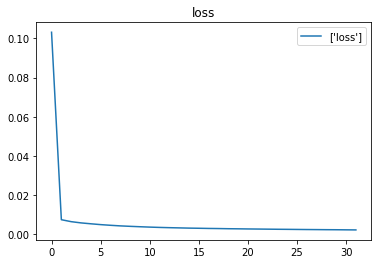

In [21]:
plot(history)

no val_mae


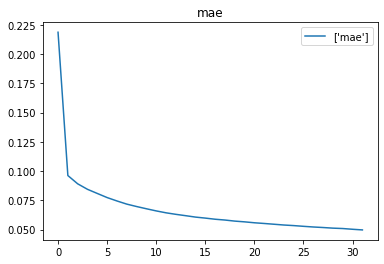

In [22]:
plot(history, 'mae')